# BPE-Segmentation PFST

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from genparse.segmentation import (
    segmentation_pfst as construction,
    fmt,
    run_segmentation_test,
)
from IPython.display import HTML

In [25]:
contexts = {"a", "b", "c", "ab", "abc"}
alphabet = set("abc")

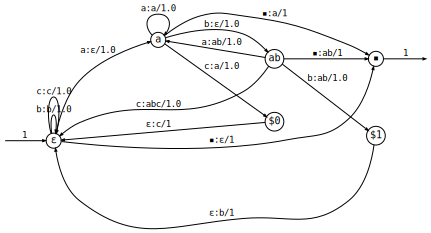

In [26]:
cc = construction(contexts, alphabet, canonical=1, debug=True)
cc.graphviz(fmt_node=fmt)

In [19]:
test_strings = [
    "aba",
    "ab",
    #'aa',
    #'acab',
    #'abc',
    #'abcabc',
    #'abcab',
]

In [27]:
C = cc
for x in test_strings:
    display(HTML(f"<hr/><h3>{x}</h3>"))
    run_segmentation_test(C, x, contexts, verbose=2)

✔ total weight: 1.0


✔ aba ('ab', 'a')


✔ total weight: 1.0


✔ ab ('ab',)


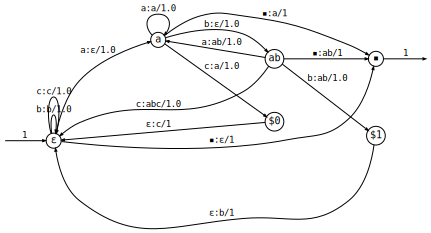

In [28]:
canonical = construction(contexts, alphabet, canonical=True)
canonical.graphviz(fmt_node=fmt)

In [29]:
for x in test_strings:
    display(HTML(f"<hr/><h3>{x}</h3>"))
    run_segmentation_test(canonical, x, contexts, verbose=1)

✔ total weight: 1.0
✔ aba ('ab', 'a')


✔ total weight: 1.0
✔ ab ('ab',)


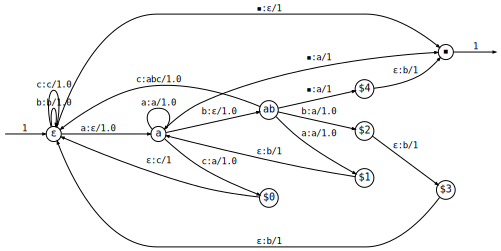

In [33]:
contexts = {"a", "b", "c", "abc"}  # not prefix closed!
alphabet = set("abc")
cc = construction(contexts, alphabet, canonical=True)
cc.graphviz(fmt_node=fmt)

In [34]:
for x in test_strings:
    display(HTML(f"<hr/><h3>{x}</h3>"))
    run_segmentation_test(cc, x, contexts, verbose=1)

✔ total weight: 1.0
✔ aba ('a', 'b', 'a')


✔ total weight: 1.0
✔ ab ('a', 'b')
